# ChessCompress, the Kijk chess challenge, for old times sake

In [1]:
# set this notebook to use a large part of the browser window width
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:80% !important; }</style>"))

## Introduction

As a young boy, my parents donated me a subscription to "Kijk". The magazine called itself "populair scientific journal" on the blue with yellow letters cover, but then in Dutch.
It still exists. It's online version is published at https://www.kijk.nl.

One month, I was probably 15 then, Kijk published a challenge that intrigued me. It was about trying to place as many chess pieces on a board without any being able to catch any other. You have an unlimited amount (or 64 if you want) of pieces of each type. However, pawns do not participate.

Clearly, if the weight by which you count would be 1 for each type, you'd just put 32 knights on all squares of a chosen color (either black or white) and be done and the score would be 32.

However, instead, each piece is counted with a certain weight depending on its type only. This type weight is equal to one over the number of pieces of that type only you could put on the board without any of the pieces being able to catch any other piece. So a queen would get 1/8 points, as one can put maximum 8 queens on a board without any queen threatening any other queen. The "Eight Queens" problem is in fact quite well known. See https://en.wikipedia.org/wiki/Eight_queens_puzzle.

A king gets 1/16 points, a rook 1/8 points, a bishop 1/14 points and a knight 1/32 points. The idea of the weights scaling is that, the more 'powerful' a piece is, the 
fewer one can typically collect on a board and so the harder it is to get many of them, so the higher the reward must be to fit more of them on the final problem. Fitting 8 queens results in a score of 8 * 1/8 = 1 but fitting 8 kings only results in a score of 8 * 1/16 = 1/2.

I puzzled a bit and my dad also helped and then we wrote a letter, which I still remember contained the hand waving argument that "Surely, the best solution could not possibly be much better than ours." A feeling of uncertainty about that claim stuck ... until now, when we actually have some tools and some time to find a better solution and also possibly prove its optimality.

I still have all my Kijk magazines at home, bundled in 3 dark blue covers, one per year, which you got when you extended your membership with a year. I should look for the results of that contest. I only remember there were quite some people that beat us at it which higher scores. So much for the handwaving argument. But before looking things up, let's try with a MILP solver. So it took 34 years for me to have time to reconsider this gem of a challenge. :)

## Spoiler Alert

You may want ot have some fun trying to find a good solution before you read on. If you don't have physical chess pieces this virtual version may help. https://lichess.org/editor/8/8/8/8/8/8/8/8_w_-_-_0_1

## Generating a clean Visualisation

To motivate ourselves even a bit more, let's first look for a nice generatable HTML representation of a chess board with its pieces positioned on it. What about this one? https://pypi.org/project/python-chess/

To install it, just uncomment the next two lines and run them from the notebook or in your system terminal.

In [2]:
%%sh
pip3 install python-chess

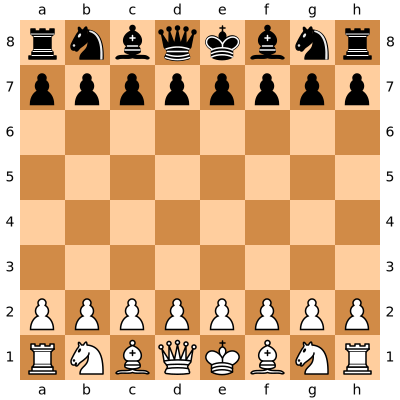

In [3]:
import chess
chess.Board()

Ha! Nice! One cannot possibly beat this representation. This took me 1 minute. Long live open source! A *good* epidemic :) 
We can also print the board in ascii with

This would be a nice generatable by code format. So can we easily specify a given board situation like this and parse it? Oh but the following 1 line string format is also easily understood when realising that the numerals stand for the number of empty squares in that row, and that the subsequent rows are separated by a / and that lower case letters are for balck pieces and upper case letters for white pieces, as in the following example.

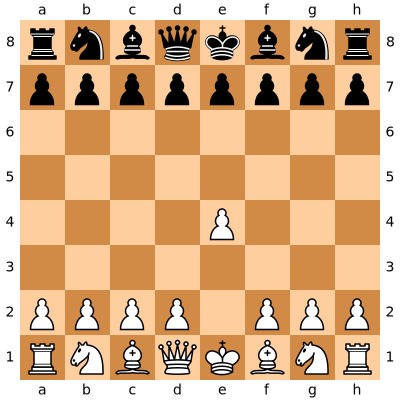

In [4]:
chess.Board("rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR")

Let's go for that format.

## Sidebar: Incrementally adding methods to a Python Class

For this challenge we want to setup one MILP model to calculate the weights per piece. Each of these problems has its own variables and constraints that will be reused exactly in the same form for the final problem. Only the final problem will have extra constraints, formulating that there cannot be two pieces of different types on the same board square.

So we will need code to constuct an empty model and then various functions that add variables and constraints to this model. This means we build up 'state' bit by bit. A logical programming construct to handle that is a Class. Let's call it Class ChessCompress. 

In regular python, one writes a Class as one piece of code, where variables and methods are contained inside the single Class definition. However, as Notebooks go, we will want to add code (chess) piece by (chess) piece. There is a way to handle that by the use of recursive class definitions.
Consider the example below, which we got from user dsblank's answer on  https://github.com/jupyter/notebook/issues/1243

In [5]:
class MyClass():
    def method1(self):
        print("method1")

In [6]:
class MyClass(MyClass):
    def method2(self):
        print("method2")

In [7]:
instance = MyClass()
instance.method1()
instance.method2()

method1
method2


So the first cell is the most regular Pythonic way to define a class and add method1. But the second cell does not simply say class MyClass() again but extends the first class by specifying class MyClass(MyClass). The third cell shows that there is no syntactic difference in calling method1 or method2. This is what we like. We can now proceed in a modular way, cell by cell, enriching the python class definition.

# Determining the weights per chess piece

We start with calculating the weights of the piece types and start with the queens problem.

## Queens Problem

If a queen takes a certain position the diagonals and row and column cannot contain another queen. To encode that, we will define binary variables q[r,c] that are 1 when we decide to put a queen in row r column c and 0 otherwise.

To solve all the below problems, we call the Mixed Integer Programming solver Gurobi (https://www.gurobi.com/) via its Python API. You will need this solver to run this notebook. We have tested this notebook with Python 3.7.6 and Gurobi 9.

In [8]:
from gurobipy import *
import itertools

In [9]:
class ChessCompress():
    
    def __init__(self, dim, piece_to_weight_dict):
        self.dim = dim
        self.m = Model()
        self.board_vars = {}  # dictionary from piece type letter 
        # to (row, col) tuple to binary solver var. 
        self.board_vals = {}  # dictionary from piece type letter 
        # to (row, col) tuple to binary result val.
        self.count = {}  # dictionary from piece type letter 
        # to number of piece fittable
        self.add_variables(piece_to_weight_dict)
        
    def derive_parameters(self, dim):
        n_rows = dim
        n_cols = dim
        rows = list(range(n_rows))
        cols = list(range(n_cols))
        return n_rows, n_cols, rows, cols

    # define the binary core variables
    def add_variables(self, piece_to_weight_dict):
        n_rows, n_cols, rows, cols = self.derive_parameters(self.dim)
        for piece_letter in piece_to_weight_dict:
            piece_weight = piece_to_weight_dict[piece_letter]
            pieces = {(r, c): -piece_weight \
                      for r, c in itertools.product(rows, cols)}
            self.board_vars[piece_letter] = \
                self.m.addVars(pieces.keys(), obj=pieces, 
                               vtype=GRB.BINARY, name=piece_letter)
    
    def add_long_range_piece_constraints(
        self, from_piece_letter, to_piece_letter, 
        piece_weight=1.0, user_cuts=True):
        
        verbose = 0
        
        from_piece_upper_letter = from_piece_letter.upper()
        to_piece_upper_letter = to_piece_letter.upper()

        n_rows, n_cols, rows, cols = self.derive_parameters(self.dim)

        # These constraints are sufficient to define 
        # the allowed search space.
        vertical_horizontal_dr_list = [ -1,  0, +1,  0] 
        vertical_horizontal_dc_list = [  0, +1,  0, -1]

        diagonal_dr_list = [ -1, +1, +1, -1]
        diagonal_dc_list = [ +1, +1, -1, -1]

        dr_list = []
        dc_list = []
        if from_piece_letter in ['q', 'r']:
            dr_list.extend(vertical_horizontal_dr_list)
            dc_list.extend(vertical_horizontal_dc_list)
        if from_piece_letter in ['q', 'b']:
            dr_list.extend(diagonal_dr_list) 
            dc_list.extend(diagonal_dc_list)
        if verbose > 0:
            print(dr_list)
            print(dc_list)
        
        for r in rows:
            for c in cols:
                # dr = delta row, cr is delta column
                for dr, dc in list(zip(dr_list, dc_list)):
                    r_, c_ = r+dr, c+dc
                    # while (d+dr, c+dc) square falls within board
                    while (r_ <= self.dim-1 and r_ >= 0) \
                        and (c_ <= self.dim-1 and c_ >= 0):  
                        constr_name = \
                            'noQBThreat_r{:d}_c{:d}_dr{:d}_dc{:d}'.\
                            format(r, c, dr, dc)
                        self.m.addConstr(\
                            self.board_vars[from_piece_letter][r,c] +\
                            self.board_vars[to_piece_letter][r_,c_] <= 1, 
                            constr_name)
                        r_, c_ = r_+dr, c_+dc
            
        # The next constraints can be optionally added.
        # They are 'user cuts' intended to speed up the solving process.
        #They do not restrict the search
        # space compared to the constraint already defined above.
        # The above constraint work on a pair of binary variables,
        # while the below 'user cut' ones work for all binary variables
        # in a full row, column or diagonal at once.
        if (from_piece_letter == to_piece_letter) and user_cuts:
            # row-wise constraints
            if from_piece_letter in ['q', 'r']:
                for r in rows:
                    constr_name = \
                        'atMostOne' + from_piece_upper_letter +\
                        'InRow_r{:d}'.format(r)
                    self.m.addConstr(
                        quicksum(self.board_vars[from_piece_letter][r,c] \
                                 for c in cols) <= 1, 
                                constr_name)

                # column-wise constraints
                for c in cols:
                    constr_name = 'atMostOne' + \
                    from_piece_upper_letter + \
                    'InCol_c{:d}'.format(c)
                    self.m.addConstr(
                        quicksum(self.board_vars[from_piece_letter][r,c] \
                                 for r in rows) <= 1, 
                                     constr_name)

            # all diagonal constraints:
            if from_piece_letter in ['q', 'b']:
                for dr, dc in [(-1, +1), (+1, +1)]:
                    if (dr, dc) == (-1, +1):
                        # go over diagonals that go RightUp
                        # start (r,c) for these diagonals are 
                        # left border of board and 
                        start_r_list = rows[1:]
                        start_c_list = [0] * (self.dim-1)
                        # lower border of board
                        start_r_list.extend([self.dim-1] * (self.dim-2))
                        start_c_list.extend(cols[1:][:-1])
                        constr_name = 'atMostOne' + \
                            from_piece_upper_letter + 'InRightUpDiag'
                    else:
                        # go over diagonals that go RightD(ow)n
                        # start (r,c) for these diagonals are 
                        # top border of board and
                        start_r_list = [0] * (self.dim-1)
                        start_c_list = cols[:-1]  # last col dropped 
                        # since would result in a 1 q var 
                        # constraint <=1 which is redundant.
                        # left border of board
                        start_r_list.extend(rows[1:][:-1])
                        start_c_list.extend([0] * (self.dim-2))
                        constr_name = 'atMostOne' + \
                            from_piece_upper_letter + 'InRightDnDiag'

                    if verbose > 0:
                        print(constr_name + ':')
                        print('  for start_r range: [' + ','.\
                              join([str(i) for i in start_r_list]) + ']')
                        print('  for start_c range: [' + ','.\
                              join([str(i) for i in start_c_list]) + ']')
                    assert len(start_r_list) == len(start_c_list)
                    for start_r, start_c in list(zip(start_r_list, start_c_list)): 
                        r, c = start_r, start_c
                        expr = LinExpr(0)
                        while (c >= 0 and c <= self.dim-1) and\
                        (r >= 0 and r <= self.dim-1):
                            if verbose > 0:
                                print(r,c)
                            expr += self.board_vars[from_piece_letter][r,c]
                            r += dr
                            c += dc
                        if verbose > 0:
                            print('---')
                        self.m.addConstr(expr <= 1, 
                                         constr_name + \
                                         '_rs{:d}cs{:d}'.format(r,c))

    def set_solver_output(self, bool):
        self.m.setParam('OutputFlag', bool)
        
    def set_time_limit(self, time_limit_in_seconds):
        self.m.setParam('TimeLimit', time_limit_in_seconds)             
            
    def solve_model(self):
        # minimise the objective function the model 
        # Since coefficients in the objective are negative this will try to 
        # maximize the number of queens in the board.
        self.m.optimize()

        # retrieve solution
        for piece_letter in self.board_vars:
            self.board_vals[piece_letter] = \
                self.m.getAttr('x', self.board_vars[piece_letter])
            # the board_vals represent the board solutions 
            # without any solver specific encoding
            self.count[piece_letter] = 0
            for r,c in self.board_vals[piece_letter]:
                if self.board_vals[piece_letter][r,c]==1:
                    self.count[piece_letter] += 1            
                
        n_different_piece_letters = len(self.board_vars.keys())        
        if n_different_piece_letters == 1:
            assert self.count[piece_letter] == \
                -int(self.m.getObjective().getValue())
        
    def get_objective_value(self):
        return self.m.getObjective().getValue()

    def get_mip_gap(self):
        return self.m.getAttr('MIPGap')
            
    def get_letter(self, r, c):
        vals = self.board_vals
        found_letter = ' ' # means nothing found yet, so empty square
        for letter in vals:
            val = int(vals[letter][(r,c)])
            if val == 1:
                assert found_letter == ' '  # can only find one letter thanks to 
                # add_at_most_a_piece_per_square_constraints being called before
                found_letter = letter
                # keep checking that no other letter is found as well
        return found_letter
        
    def encode_to_fen_board_string(self, capitals_for_white=False):
        vals = self.board_vals
        n_rows, n_cols, rows, cols = self.derive_parameters(self.dim)
        s = ''
        space = ' '
        for r in rows:
            for c in cols:  # we assume these couples  lexically sorted
                letter = self.get_letter(r,c)
                bw_letter = letter.upper() if capitals_for_white else letter
                if self.dim == 8:  # then we keep to the standard fen format 
                    # since we can use chess.Board(on it) later
                    if letter != ' ':
                        s += bw_letter
                    else:
                        assert letter == ' '
                        if (len(s) == 0):
                            s = '1'
                        elif s[-1] in ['1','2','3','4','5','6','7','8','9']:
                            s = s[:-1] + str(int(s[-1])+1)
                        else:  # increment last digit of s
                            s += '1'

                    if c == self.dim-1:
                        if r != self.dim-1:
                            s += '/'
                else: # The additional 'space' here is 
                    # there to end up with square boards
                    if letter != ' ':
                        s += bw_letter + space
                    else:
                        assert letter == ' '
                        s += '.' + space
                        
                    if c == self.dim-1:
                        if r != self.dim-1:
                            s += '\n'

        return s
        
cc_queens = ChessCompress(8, {'q' : 1.0})
cc_queens.add_long_range_piece_constraints('q', 'q')
cc_queens.set_solver_output(True)
cc_queens.solve_model()
print('I could maximally fit {:d} queens on the chess board.'.\
      format(cc_queens.count['q']))
n_queens = cc_queens.count['q']

Using license file /Library/gurobi901/gurobi.lic
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 1498 rows, 64 columns and 3164 nonzeros
Model fingerprint: 0x5e6db8b3
Variable types: 0 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -5.0000000
Presolve removed 1456 rows and 0 columns
Presolve time: 0.00s
Presolved: 42 rows, 64 columns, 270 nonzeros
Variable types: 0 continuous, 64 integer (64 binary)

Root relaxation: objective -8.000000e+00, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -8.0000000  -64.00000   700%     -    0s
     0     0   

So that took only 10 miliseconds. Not a lot. :) We allowed the solver to output it's log here, to show you that a solver is called. In the next notebook cells we will avoid that by calling set_solver_output(False) instead.

Let's now display the 8 queens on the board. We need to generate that string encoding.

3Q4/5Q2/7Q/2Q5/Q7/6Q1/4Q3/1Q6


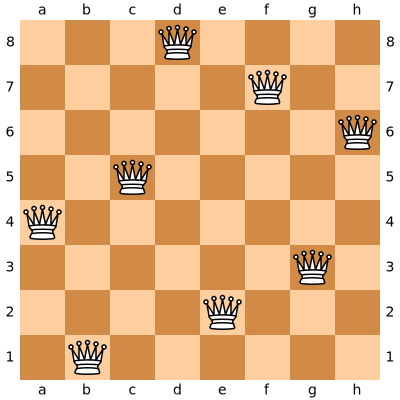

In [10]:
board_string = \
    cc_queens.encode_to_fen_board_string(capitals_for_white=True)
print(board_string)
chess.Board(board_string)

We can indeed visually check that each row and column has at most one queen. Also on each diagonal we have at most one queen. This is one solution and there are of course other, even only due to symmetries alone. For example by flipping the queen positions along the horizontal axis or vertical azis in the moddle of the board. Also a multiple of 90 degrees rotations of the queens positions delivers new solutions.

In fact the wikipedia page https://en.wikipedia.org/wiki/Eight_queens_puzzle mentions a more symmetrical version reproduced here below.

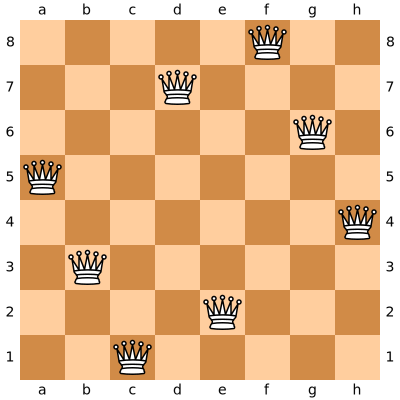

In [11]:
chess.Board('5Q2/3Q4/6Q1/Q7/7Q/1Q6/4Q3/2Q5')

In any case, because we can maximally fit 8 queens, the score of the type queen will be 1/8 in the final problem.

## Bishops Problem

Hmm, we have done this one before. We should reuse the diagonal constraints we defined for the queens. 'Not entirely accidentally', we have written up the queens problem so that we can just call the function add_long_range_piece_variables_and_constraints(piece_letter) with piece letter='b' and we're done with the bishops. Let's try.

I could maximally fit 14 bishops on the chess board.
BB2B1B1/8/B6B/B7/7B/B6B/8/BB1B2B1


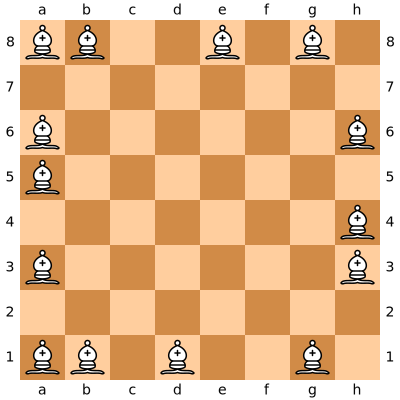

In [12]:
cc_bishops = ChessCompress(8, {'b': 1.0})
cc_bishops.add_long_range_piece_constraints('b','b')
cc_bishops.m.setParam('OutputFlag', False)
cc_bishops.solve_model()
print('I could maximally fit {:d} bishops on the chess board.'.\
      format(cc_bishops.count['b']))
n_bishops = cc_bishops.count['b']

board_string = \
    cc_bishops.encode_to_fen_board_string(\
        capitals_for_white=True)
print(board_string)
chess.Board(board_string)

So 14 bishops can be fitted and the bishops weight in the final problem becomes 1/14.

## Rooks Problem

Done before for queens. Let's reuse that. Hmm, I wonder if Gurobi is going to put all the rooks on the diagonal... Let's see.

I could maximally fit 8 rooks on the chess board.
R7/1R6/2R5/3R4/4R3/5R2/6R1/7R


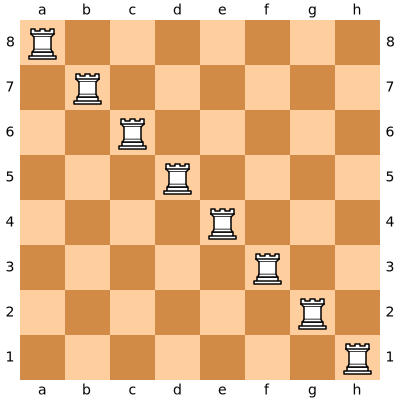

In [13]:
cc_rooks = ChessCompress(8, {'r':1.0})
cc_rooks.add_long_range_piece_constraints('r', 'r')
cc_rooks.m.setParam('OutputFlag', False)
cc_rooks.solve_model()
print('I could maximally fit {:d} rooks on the chess board.'.\
      format(cc_rooks.count['r']))
n_rooks = cc_rooks.count['r']

board_string = \
    cc_rooks.encode_to_fen_board_string(capitals_for_white=True)
print(board_string)
chess.Board(board_string)

So 8 rooks can be fitted and the rook's weight in the final problem becomes 1/8.

Yes, the diagonal it is! There are obviously many other possible solutions, all with the same number of rooks: 8. Let's write up the problem for the kings now.

## Kings Problem

Kings are like queens in the sense that they can attack or threaten other pieces in the same directions: up, down, left, right and the 4 diagonal directions, but their reach is only one square instead of the whole row, column or diagonal. So the problem is similar, but the constraints only span two subsequent squares in these same directions.

I could maximally fit 16 kings on the chess board.
K1K2K1K/8/K1K2K1K/8/8/K1K2K1K/8/K1K2K1K


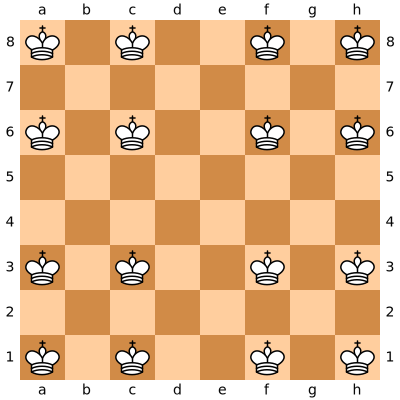

In [14]:
class ChessCompress(ChessCompress):  # extend the class
    
    def add_kings_constraints(self, to_piece_letter, 
                              piece_weight=1.0):
        n_rows, n_cols, rows, cols = self.derive_parameters(self.dim)
        kings = {(r, c): -piece_weight for r, 
                 c in itertools.product(rows, cols)}

        n_rows, n_cols, rows, cols = \
            self.derive_parameters(self.dim)
        kings = {(r, c): -piece_weight for r, 
                 c in itertools.product(rows, cols)}

        for r in rows:
            for c in cols:
                # dr = delta row, cr is delta column
                dr_list = [ -1,  0, +1, +1, +1, 0, -1, -1]
                dc_list = [ +1, +1, +1,  0, -1, -1, -1, 0]
                for dr, dc in list(zip(dr_list, dc_list)):
                    if (r+dr <= self.dim-1 and r+dr >= 0) \
                        and (c+dc <= self.dim-1 and c+dc >= 0):  
                        # if (d+dr, c+dc) square falls within board
                        constr_name = \
                            'noKingsThreat_r{:d}_c{:d}_dr{:d}_dc{:d}'.\
                        format(r, c, dr, dc)
                        self.m.addConstr(
                            self.board_vars['k'][r,c] + 
                            self.board_vars[to_piece_letter][r+dr,c+dc] <= 1, 
                            constr_name)

cc_kings = ChessCompress(8, {'k':1.0})
cc_kings.add_kings_constraints('k')
cc_kings.m.setParam('OutputFlag', False)
cc_kings.solve_model()
print('I could maximally fit {:d} kings on the chess board.'.
      format(cc_kings.count['k']))
board_string = \
    cc_kings.encode_to_fen_board_string(capitals_for_white=True)
n_kings = cc_kings.count['k']

print(board_string)
chess.Board(board_string)

Another 10 ms wasted. :) 

So 16 kings can be fitted and the king's weight in the final problem becomes 1/16.

Let's go for the knights problem, which is quite different.

## Knights Problem

I could maximally fit 32 knights on the chess board.
The board setup scores 32.000000.
N1N1N1N1/1N1N1N1N/N1N1N1N1/1N1N1N1N/N1N1N1N1/1N1N1N1N/N1N1N1N1/1N1N1N1N


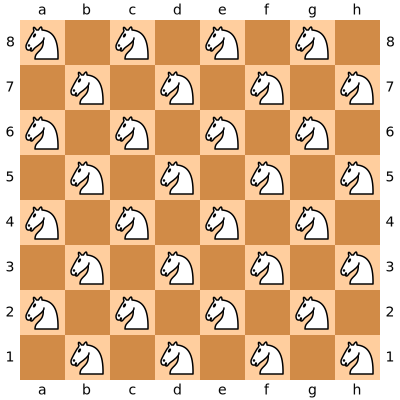

In [15]:
class ChessCompress(ChessCompress):  # extend the class
    
    def add_knights_constraints(self, to_piece_letter, piece_weight=1.0):
        verbose = 0

        n_rows, n_cols, rows, cols = self.derive_parameters(self.dim)
        kings = {(r, c): -piece_weight for r, c in itertools.product(rows, cols)}

        # define the basic Constraints

        # row-wise constraints
        for r in rows:
            for c in cols:
                # dr = delta row, cr is delta column
                dr_list = [-2, -1, +1, +2, +2, +1, -1, -2]
                dc_list = [+1, +2, +2, +1, -1, -2, -2, -1]
                for dr, dc in list(zip(dr_list, dc_list)):
                    if (r+dr <= self.dim-1 and r+dr >= 0) \
                        and (c+dc <= self.dim-1 and c+dc >= 0):  
                        # if (d+dr, c+dc) square falls within board
                        constr_name = \
                            'noTwoNWithinSingleJump_r{:d}_c{:d}_dr{:d}_dc{:d}'.\
                            format(r, c, dr, dc)
                        self.m.addConstr(
                            self.board_vars['n'][r,c] + 
                            self.board_vars[to_piece_letter][r+dr,c+dc] <= 1, 
                            constr_name)

cc_knights = ChessCompress(8, {'n':1.0})
cc_knights.add_knights_constraints('n')
cc_knights.m.setParam('OutputFlag', False)
cc_knights.solve_model()
print('I could maximally fit {:d} knights on the chess board.'.
      format(cc_knights.count['n']))
print('The board setup scores {:f}.'.format(-cc_knights.get_objective_value()))

board_string = cc_knights.encode_to_fen_board_string(capitals_for_white=True)
n_knights = cc_knights.count['n']
print(board_string)
chess.Board(board_string)

So 32 knights is the maximum fittable on a board, so they get the weight of 1/32 in the final problem. They are on (all) the squares of one color only, white here, but another solution would be for them on all the black squares. 

Let's summarize by writing a function that calculates the weights for a given board dimension.

In [16]:
def calculate_piece_weights(dim, user_cuts=True, 
                            capitals_for_white=True, solver_output=False):
    weights = {}
    boards = {}
    
    cc = ChessCompress(dim, {'k':1.0})
    cc.add_kings_constraints('k')
    cc.set_solver_output(solver_output)
    cc.solve_model()
    
    weights['k'] = 1/(-cc.get_objective_value())
    s = cc.encode_to_fen_board_string(capitals_for_white)
    boards['k'] = chess.Board(s) if dim == 8 else HTML(s)
    for piece_letter in ['q', 'b', 'r']:
        cc = ChessCompress(dim, {piece_letter:1.0})
        cc.add_long_range_piece_constraints(piece_letter, piece_letter, 
                                            {piece_letter:1.0}, user_cuts)
        cc.set_solver_output(solver_output)
        cc.solve_model()
        weights[piece_letter] = 1/(-cc.get_objective_value())
        s = cc.encode_to_fen_board_string(capitals_for_white)
        boards[piece_letter] = chess.Board(s) if dim == 8 else HTML(s)

    cc = ChessCompress(dim, {'n':1.0})
    cc.add_knights_constraints('n')
    cc.set_solver_output(solver_output)
    cc.solve_model()
    weights['n'] = 1/(-cc.get_objective_value())
    s = cc.encode_to_fen_board_string(capitals_for_white)
    boards['n'] = chess.Board(s) if dim == 8 else HTML(s)
     
    return weights, boards

weights_dim8, boards = calculate_piece_weights(8, user_cuts=True, 
                                               capitals_for_white=False)
for key, val in weights_dim8.items():
    print(key, int(1/val))
print(weights_dim8)

k 16
q 8
b 14
r 8
n 32
{'k': 0.0625, 'q': 0.125, 'b': 0.07142857142857142, 'r': 0.125, 'n': 0.03125}


# The Real Problem

## Teams, assume position

Hmm, shall we try to already piece things together? Surely we still have to add a constraint saying that any square can contain at most one chess piece.

### Plain Vanilla Model

In [17]:
class ChessCompress(ChessCompress):  # extend the class

    def add_at_most_a_piece_per_square_constraints(self):
        n_rows, n_cols, rows, cols = self.derive_parameters(self.dim)
        for r in rows:
            for c in cols:
                constr_name = \
                'atMostOnePiecePerSquare_r{:d}_c{:d}'.format(r, c)
                self.m.addConstr(
                    quicksum(self.board_vars[letter][r,c] 
                             for letter in self.board_vars) <= 1, 
                    constr_name)

Needed 91.214477 seconds to find optimal solution.
I could maximally fit 5 queens, 15 kings, 10 bishops,
  26 knights and 7 rooks together on the chess board.
The board setup scores 63.000000.
NKBKNKNR/RNBNQNBB/NQNKNKNK/KBRN1QBN/NBNRNKNK/KBKNRBQN/NRNQNBNK/KNKNKNRN


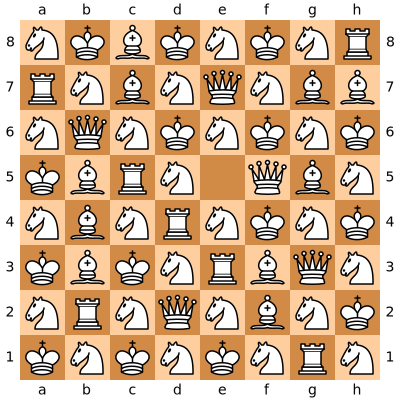

In [18]:
def max_pieces_on_board_forbidding_threat_within_own_type_only(
    piece_weights, user_cuts=False, solver_output=False):
    
    cc_all = ChessCompress(8, piece_weights)
    for piece_letter in ['q', 'b', 'r']:
        cc_all.add_long_range_piece_constraints(
            piece_letter, piece_letter,
            piece_weights[piece_letter], user_cuts)
    cc_all.add_kings_constraints('k')
    cc_all.add_knights_constraints('n')
    cc_all.add_at_most_a_piece_per_square_constraints()
    cc_all.set_solver_output(solver_output)
    cc_all.solve_model()
    solver_time_in_seconds = cc_all.m.getAttr('Runtime')
    print('Needed {:f} seconds to find optimal solution.'.format(
        solver_time_in_seconds))
    print('I could maximally fit {:d} queens, {:d} kings, {:d} bishops,'.
          format(cc_all.count['q'], cc_all.count['k'], cc_all.count['b']))
    print('  {:d} knights and {:d} rooks together on the chess board.'.
          format(cc_all.count['n'], cc_all.count['r']))

    print('The board setup scores {:f}.'.format(-cc_all.get_objective_value()))

    board_string = cc_all.encode_to_fen_board_string(capitals_for_white=True)
    print(board_string)
    board = chess.Board(board_string)
    return board

max_pieces_on_board_forbidding_threat_within_own_type_only(
    piece_weights={'q':1, 'k':1, 'b':1, 'r':1, 'n':1}, 
    user_cuts=False)

Now that's surprising: 63 pieces could be fit but nothing in the last square. 


### Improving Time to Solution by Adding  User Cuts

The above problem takes 98 seconds to solve on my laptop. Maybe this time can be improved with adding the above mentioned user cuts. Let's try.

Needed 7.577194 seconds to find optimal solution.
I could maximally fit 5 queens, 15 kings, 8 bishops,
  28 knights and 7 rooks together on the chess board.
The board setup scores 63.000000.
KNKNKNRN/NRNBNQNK/KNKNKNBQ/NQN1NRNK/KNKNRNQN/BBQRNKNK/KNRBBNBN/NNNKNKBR


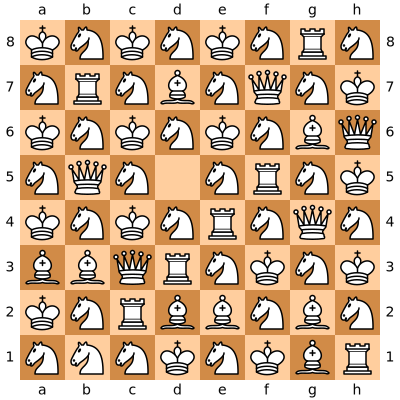

In [19]:
max_pieces_on_board_forbidding_threat_within_own_type_only(
    piece_weights={'q':1, 'k':1, 'b':1, 'r':1, 'n':1}, 
    user_cuts=True)

Yes! We only need about 7 seconds when including the user cuts. So this shows how big an effect this can have. In fact user cuts in business questions can come from business logic. It is something the solver cannot automatically identify, but the human modeller can add by having some higher level insight.

The solution has of course the same 'quality', objective function value -63 as the previous one without user cuts, but it need not be the same, and indeed here it isn't. Such is the nature of user cuts.


## Adding the Correct Weights per Chess Piece

For now, we have weighted pieces with the same weight 1. Maybe if weigh them differently, we get a different structure. Let's try.

Needed 51.763954 seconds to find optimal solution.
I could maximally fit 8 queens, 16 kings, 13 bishops,
  16 knights and 8 rooks together on the chess board.
The board setup scores 4.428571.
RKBKQBNK/BNQN1KRB/QKNKNRNK/BN1NRKQB/BQKRNBNB/KNRNKNKQ/BBN1NQNR/KRKQKBKB


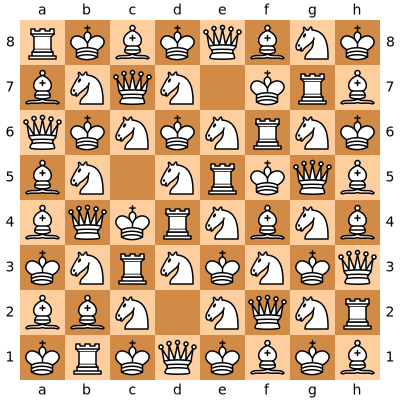

In [20]:
max_pieces_on_board_forbidding_threat_within_own_type_only(
    piece_weights={'q':1/n_queens, 'k':1/n_kings, 
                   'b':1/n_bishops, 'r':1/n_rooks, 
                   'n':1/n_knights}, 
    user_cuts=True)

This takes about 390 seconds on my laptop, even with the same user cuts. It seems the coefficients being different from 1 make choices between piece types harder. Note that until now, we have ignored to forbid any attacking between pieces of a different type. Let's add that now.

## Now, also be kind to others

So we are now additionally imposing that pieces of different families do not threaten each other. So they kind of have to practice some social distancing now. :) This then becomes the final problem we wanted to solve.

Needed 26.642479 seconds to find this solution.
With this objective, this solution contains: 0 q, 9 k, 6 b, 1 r, 7 n
The board setup scores 1.334821.
This optimal solution's MIP gap equals: 0.00
1N1K1K1K/R7/1N1K1K1N/1B5B/1N1K1K1N/1B5B/1N1K1K1N/1B5B


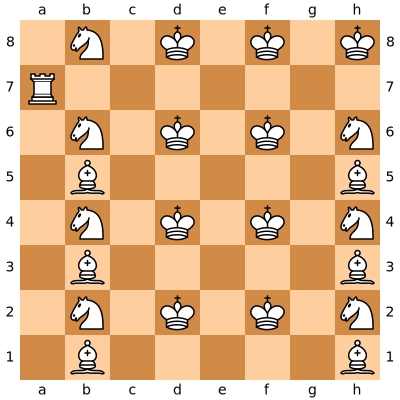

In [21]:
def kijk_chess_challenge(
    dim=8,
    piece_weights={'q':1/n_queens, 'k':1/n_kings, 
                   'b':1/n_bishops, 'r':1/n_rooks, 'n':1/n_knights}, 
    user_cuts=True,
    solver_output=False,
    solver_seconds=48*3600):
    
    all_pieces = piece_weights.keys()
    long_range_pieces = set(['q', 'b', 'r']).\
        intersection(piece_weights.keys())
    cc_all = ChessCompress(dim, piece_weights)
    cc_all.set_solver_output(solver_output)
    for to_piece_letter in all_pieces:
        for from_piece_letter in long_range_pieces:
            cc_all.add_long_range_piece_constraints(from_piece_letter, 
                                                    to_piece_letter, 
                                                    user_cuts)
        if 'k' in piece_weights.keys():
            cc_all.add_kings_constraints(to_piece_letter)
        if 'n' in piece_weights.keys():
            cc_all.add_knights_constraints(to_piece_letter)
    cc_all.add_at_most_a_piece_per_square_constraints()
    
    cc_all.set_solver_output(solver_output)
    cc_all.set_time_limit(solver_seconds)
    cc_all.solve_model()
    
    solver_time_in_seconds = cc_all.m.getAttr('Runtime')
    print('Needed {:f} seconds to find this solution.'.\
          format(solver_time_in_seconds))
    s = []
    for piece_letter in piece_weights.keys():
        s.append('{:d} {:s}'.format(cc_all.count[piece_letter], 
                                    piece_letter))
    print('With this objective, this solution contains: ' +\
          ', '.join(s))
    print('The board setup scores {:f}.'.\
          format(-cc_all.get_objective_value()))
    mip_gap = cc_all.get_mip_gap()
    print('This ' + ('suboptimal' if mip_gap>0.0 else 'optimal') 
          + ' solution\'s MIP gap equals: {:.2f}'.\
          format(cc_all.get_mip_gap()))
    
    board_string = \
    cc_all.encode_to_fen_board_string(
        capitals_for_white=True)
    print(board_string)
    if dim==8:
        board = chess.Board(board_string)
        return board
    else:
        pass

kijk_chess_challenge()

In [22]:
n_queens, n_kings, n_bishops, n_knights, n_rooks

(8, 16, 14, 32, 8)

So that only took 30 seconds to solve! The top score, given by this solution found by Gurobi is $1.334821428571$. Gurobi says: "No other solutions better than -1.33482" and that means it has proven this solution is optimal. To be totally exact about the final number, we can express it in rational number notation.

The $9$ kings give score $9/16$, 6 bishops give $6/14$, 7 knights give $7/32$ and the 1 rook gives $1/8$, together that makes 9/16 + 6/14 + 7 / 32 + 1/8 = (18 + 7 + 4) / 32 + 6 / 14 = (29 * 7)/(32 * 7) + (6 * 16)/(14 * 16) = 203 / 224 + 96 / 224 = 299 / 224.

$\square$

# Problem Variations

We can now easily code variations of the problem.

## Second Division

So queens do not occur and kings and horses occur abundantly. So what happens if we exclude kings and horses from the game?

Needed 2.742527 seconds to find this solution.
With this objective, this solution contains: 4 q, 8 b, 0 n
The board setup scores 1.071429.
This optimal solution's MIP gap equals: 0.00
2B2BBB/8/1Q6/6BB/Q7/3Q4/6BB/4Q3


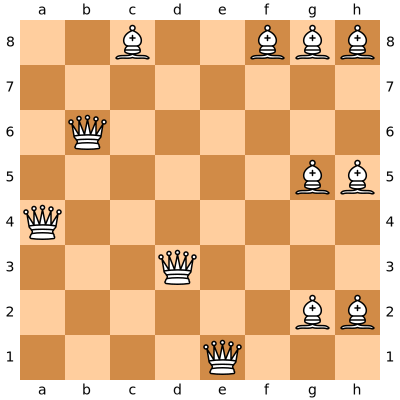

In [23]:
kijk_chess_challenge(
    dim=8, 
    piece_weights={'q':1/n_queens, 'b':1/n_bishops, 'n':1/n_knights}, 
    user_cuts=True,
    solver_output=False)

This took less than 3 seconds. So also with only 2 chess piece types we can get above a score of 1. Rooks do not occur here because all empty squares are under threat.

## Mixed Division

Can we define a problem to which the optimal solution contains all the piece types, by discouraging the use of kings and knights a bit? For that we can give these first division players a small handicap. Let's try.

Needed 24.228666 seconds to find this solution.
With this objective, this solution contains: 0 q, 1 k, 7 b, 4 r, 6 n
The board setup scores 1.216667.
This optimal solution's MIP gap equals: 0.00
1B3BNB/3R4/4R3/1N3NBB/2R5/1N5K/R7/1N3NBB


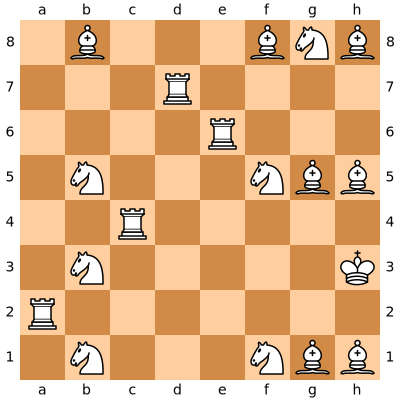

In [24]:
kijk_chess_challenge(
    dim=8,
    piece_weights={'q':1/n_queens, 'k':1/(n_kings+4), 'b':1/n_bishops, 
                   'r':1/n_rooks, 'n':1/(n_knights+4)}, 
    user_cuts=True,
    solver_output=False
)

The solver took 47 seconds and makes an interesting combination of 4 piece types but no queens. Queens don't seem to combine so well with other pieces apart from bishops.

## Scale Down

Scaling down a problem is often a good way to debug a model more easily.

### A 4x4 chess board

In [25]:
weights_dim4, boards = \
    calculate_piece_weights(4, user_cuts=True, 
                            capitals_for_white=False)
print(weights_dim4)
kijk_chess_challenge(dim=4, piece_weights=weights_dim4, 
                     user_cuts=True, solver_output=False)

{'k': 0.25, 'q': 0.25, 'b': 0.16666666666666666, 'r': 0.25, 'n': 0.125}
Needed 0.125075 seconds to find this solution.
With this objective, this solution contains: 2 k, 0 q, 0 b, 2 r, 2 n
The board setup scores 1.250000.
This optimal solution's MIP gap equals: 0.00
K . . N 
. . R . 
. R . . 
N . . K 


### A 3x3 chess board

In [26]:
weights_dim3, boards = \
calculate_piece_weights(3, user_cuts=True, 
                        capitals_for_white=False)
print(weights_dim3)
kijk_chess_challenge(dim=3, piece_weights=weights_dim3, 
                     user_cuts=True, solver_output=False)

{'k': 0.25, 'q': 0.5, 'b': 0.25, 'r': 0.3333333333333333, 'n': 0.2}
Needed 0.018435 seconds to find this solution.
With this objective, this solution contains: 0 k, 1 q, 0 b, 2 r, 0 n
The board setup scores 1.166667.
This optimal solution's MIP gap equals: 0.00
. . Q 
R . . 
. R . 


### A 2x2 chess board

In [27]:
weights_dim2, boards = \
    calculate_piece_weights(2, user_cuts=True, 
                            capitals_for_white=False)
print(weights_dim2)
kijk_chess_challenge(dim=2, piece_weights=weights_dim2, 
                     user_cuts=True, solver_output=False)

{'k': 1.0, 'q': 1.0, 'b': 0.5, 'r': 0.5, 'n': 0.25}
Needed 0.000808 seconds to find this solution.
With this objective, this solution contains: 0 k, 1 q, 0 b, 0 r, 0 n
The board setup scores 1.000000.
This optimal solution's MIP gap equals: 0.00
. . 
. Q 


### A 1x1 chess board

In [28]:
weights_dim1, boards = \
calculate_piece_weights(1, user_cuts=True, 
                        capitals_for_white=False)
print(weights_dim1)
kijk_chess_challenge(dim=1, piece_weights=weights_dim1, 
                     user_cuts=True, solver_output=False)

{'k': 1.0, 'q': 1.0, 'b': 1.0, 'r': 1.0, 'n': 1.0}
Needed 0.000146 seconds to find this solution.
With this objective, this solution contains: 0 k, 1 q, 0 b, 0 r, 0 n
The board setup scores 1.000000.
This optimal solution's MIP gap equals: 0.00
Q 


## Scale Up

Scaling up a problem is a good way to check performance for real world applications. Here it's just play of course or solver testing at best. :)

### A 9x9 board

In [29]:
weights_dim9, boards = \
    calculate_piece_weights(9, user_cuts=True, 
                            capitals_for_white=False)
print(weights_dim9)
kijk_chess_challenge(dim=9, piece_weights=weights_dim9, 
                     user_cuts=True, solver_output=False)

{'k': 0.04, 'q': 0.1111111111111111, 'b': 0.0625, 'r': 0.1111111111111111, 'n': 0.024390243902439025}
Needed 53.215959 seconds to find this solution.
With this objective, this solution contains: 15 k, 0 q, 8 b, 0 r, 10 n
The board setup scores 1.343902.
This optimal solution's MIP gap equals: 0.00
N . K . K . K . N 
B . . . . . . . B 
N . K . K . K . N 
B . . . . . . . B 
N . K . K . K . N 
B . . . . . . . B 
N . K . K . K . N 
B . . . . . . . B 
N . K . K . K . N 


Calculated in 75 seconds, ... ooh that's a nice and regular 'optimal' structure! :)

### A 10x10 board

In [30]:
weights_dim10, boards = \
    calculate_piece_weights(10, user_cuts=True, 
                            capitals_for_white=False)
print(weights_dim10)
kijk_chess_challenge(dim=10, piece_weights=weights_dim10, 
                     user_cuts=True, solver_output=False)

{'k': 0.04, 'q': 0.1, 'b': 0.05555555555555555, 'r': 0.1, 'n': 0.02}
Needed 279.702006 seconds to find this solution.
With this objective, this solution contains: 11 k, 0 q, 7 b, 3 r, 13 n
The board setup scores 1.388889.
This optimal solution's MIP gap equals: 0.00
. K . N . N B N . K 
. . . . R . . . . . 
. N . N . . . K . K 
. . R . . . . . . . 
. N . N . K . K . K 
R . . . . . . . . . 
. N . K . N . K . N 
. B . . . B . . . B 
. N . K . N . K . N 
. B . . . B . . . B 


A similar structure, calculated in 252 seconds.

### A 11x11 board

In [31]:
weights_dim11, boards = \
    calculate_piece_weights(11, user_cuts=True, 
                            capitals_for_white=False)
print(weights_dim11)
kijk_chess_challenge(dim=11, piece_weights=weights_dim11, 
                     user_cuts=True, solver_output=False)

{'k': 0.027777777777777776, 'q': 0.09090909090909091, 'b': 0.05, 'r': 0.09090909090909091, 'n': 0.01639344262295082}
Needed 1181.096910 seconds to find this solution.
With this objective, this solution contains: 15 k, 0 q, 8 b, 3 r, 19 n
The board setup scores 1.400869.
This optimal solution's MIP gap equals: 0.00
K . N . K . N . K . N 
. . B . . . B . . . B 
K . N . K . N . K . N 
. . B . . . B . . . B 
K . N . . . N . K . N 
. . . R . . . . . . . 
N . N . N . K . K . K 
. R . . . . . . . . . 
N . N . K . K . . . N 
. . . . . . . . . R . 
K . K . N B N B N . N 


So that took 1241 seconds to reach the optimal solution. 

### A 12x12 board

In [32]:
weights_dim12, boards = \
    calculate_piece_weights(12, user_cuts=True, 
                            capitals_for_white=False)
print(weights_dim12)
kijk_chess_challenge(dim=12, piece_weights=weights_dim12, 
                     user_cuts=True, 
                     solver_output=False, solver_seconds=3*60)

{'k': 0.027777777777777776, 'q': 0.08333333333333333, 'b': 0.045454545454545456, 'r': 0.08333333333333333, 'n': 0.013888888888888888}
Needed 180.013574 seconds to find this solution.
With this objective, this solution contains: 15 k, 0 q, 9 b, 4 r, 19 n
The board setup scores 1.422980.
This suboptimal solution's MIP gap equals: 0.22
. B . . N . . B . . . B 
. N . . B . . N . K . N 
. B . . . . . B . . . B 
. N . K . K . N . K . N 
R . . . . . . . . . . . 
. N . N . K . K . K . K 
. . R . . . . . . . . . 
. N . N . K . K . N . N 
. . . . . . . . . . R . 
. K . K . K . . . N . N 
. . . . . . . . R . . . 
. K . N B N B N . N . K 


The above solution is only the one found after 10 minutes.
The optimal solution calculated earlier took 34125.92 to calculate and is:
<pre>
No other solutions better than -1.42298
Optimal solution found (tolerance 1.00e-04)
Best objective -1.422979797980e+00, best bound -1.422979797980e+00, gap 0.0000%
Needed 34126.014710 seconds to find optimal solution.
With this objective, the best solution contains:
  , 15 k, 0 q, 9 b, 4 r, 19 n
The board setup scores 1.422980.
<pre>
K . N . N . K . N B N B 
. . . R . . . . . . . . 
N . N . N . K . K . K . 
. R . . . . . . . . . . 
N . . . K . K . N . . B 
B . . . . . . . B . . N 
N . K . K . K . N . . B 
B . . . . . . . . . . . 
N . K . N . N . K . K . 
. . . . . R . . . . . . 
K . K . N . N . N B N B 
. . . . . . . R . . . . 
</pre>

### A 13x13 board

In [33]:
weights_dim13, boards = \
    calculate_piece_weights(13, user_cuts=True, 
                            capitals_for_white=False)
print(weights_dim13)
kijk_chess_challenge(dim=13, piece_weights=weights_dim13, 
                     user_cuts=True, solver_output=False,
                     solver_seconds=3*60)

{'k': 0.02040816326530612, 'q': 0.07692307692307693, 'b': 0.041666666666666664, 'r': 0.07692307692307693, 'n': 0.011764705882352941}
Needed 180.022740 seconds to find this solution.
With this objective, this solution contains: 24 k, 0 q, 10 b, 3 r, 24 n
The board setup scores 1.419585.
This suboptimal solution's MIP gap equals: 0.24
K . N . K . N B N B N B N 
. . B . . . . . . . . . . 
K . N . K . K . K . K . K 
. . . . . . . . . . . . . 
N . N . K . K . K . K . K 
. R . . . . . . . . . . . 
N . N . N . N . N B N B N 
. . . . . R . . . . . . . 
K . N . N . N . K . K . K 
. . . R . . . . . . . . . 
K . N . . . K . K . K . K 
. . B . . . . . . . . . . 
K . N . K . N B N B N B N 


The above did instead take 10668 seconds when run up to the optimal solution, which is:
<pre>  
Optimal solution found (tolerance 1.00e-04)
Best objective -1.467456213255e+00, best bound -1.467456213255e+00, gap 0.0000%
Needed 10668.292165 seconds to find optimal solution.
With this objective, the best solution contains:
  , 22 k, 0 q, 10 b, 4 r, 25 n
The board setup scores 1.467456.
K . K . K . N . N B N B N 
. . . . . . . R . . . . . 
K . K . N . N . . . K . K 
. . . . . R . . . . . . . 
N . K . N . N . N B N B N 
B . . . . . . . . . . . . 
N . K . K . K . K . K . K 
B . . . . . . . . . . . . 
N . . . K . K . N B N B N 
. R . . . . . . . . . . . 
N . N . N . K . K . K . K 
. . . R . . . . . . . . . 
K . N . N . K . N B N B N 
</pre>  

### A 14x14 board

From here onwards, things take more time. After 90000 seconds the solver wat only just below 5% removed from the lower bound to the optimal solution.

In [34]:
weights_dim14, boards = \
    calculate_piece_weights(14, user_cuts=True, 
                            capitals_for_white=False)
print(weights_dim14)
kijk_chess_challenge(dim=14, piece_weights=weights_dim14, 
                     user_cuts=True, solver_output=False, 
                     solver_seconds=3*60)

{'k': 0.02040816326530612, 'q': 0.07142857142857142, 'b': 0.038461538461538464, 'r': 0.07142857142857142, 'n': 0.01020408163265306}
Needed 180.063057 seconds to find this solution.
With this objective, this solution contains: 29 k, 0 q, 12 b, 3 r, 16 n
The board setup scores 1.430926.
This suboptimal solution's MIP gap equals: 0.28
K . K . K . K . K . N . . B 
. . . . . . . . . . . R . . 
N . K . K . K . K . N . . B 
B . . . . . . . . . . . . N 
N . K . K . K . K . K . . B 
B . . . . . . . . . . . . N 
N . K . N B N . K . K . . B 
B . . . . . . . . . . . . N 
N . K . K . K . K . K . . B 
B . . . . . . . . . . . . N 
N . . . K . K . K . K . . B 
. R . . . . . . . . . . . . 
N . N . N . K . K . K . . B 
. . . R . . . . . . . . . . 


The above is calculated in 10 minutes time restriction.
One run took 90000 seconds to calculate a solution still 5% removed from the lower bound to the optimal solution.

### A 15x15 board

In [35]:
weights_dim15, boards = \
    calculate_piece_weights(15, user_cuts=True, 
                            capitals_for_white=False)
print(weights_dim15)
kijk_chess_challenge(dim=15, piece_weights=weights_dim15, 
                     user_cuts=True, solver_output=False, 
                     solver_seconds=3*60)

{'k': 0.015625, 'q': 0.06666666666666667, 'b': 0.03571428571428571, 'r': 0.06666666666666667, 'n': 0.008849557522123894}
Needed 180.099953 seconds to find this solution.
With this objective, this solution contains: 35 k, 0 q, 14 b, 3 r, 27 n
The board setup scores 1.485813.
This suboptimal solution's MIP gap equals: 0.20
N B N B N . K . N . N B N B N 
. . . . . . . . . R . . . . . 
K . K . K . K . N . . . K . K 
. . . . . . . . . . . . . . . 
N . K . K . K . K . K . K . N 
B . . . . . . . . . . . . . B 
N . K . K . K . K . K . K . N 
B . . . . . . . . . . . . . B 
N . K . K . K . K . K . K . N 
B . . . . . . . . . . . . . B 
N . K . K . N . N . K . K . N 
. . . . . . . R . . . . . . . 
K . K . . . N . N . K . K . K 
. . . . . R . . . . . . . . . 
N B N B N . N . K . N B N B N 


### A 16x16 board

In [36]:
weights_dim16, boards = \
    calculate_piece_weights(16, user_cuts=True, 
                            capitals_for_white=False)
print(weights_dim16)
kijk_chess_challenge(dim=16, piece_weights=weights_dim16, 
                     user_cuts=True, solver_output=False, 
                     solver_seconds=3*60)

{'k': 0.015625, 'q': 0.0625, 'b': 0.03333333333333333, 'r': 0.0625, 'n': 0.0078125}
Needed 180.024002 seconds to find this solution.
With this objective, this solution contains: 36 k, 0 q, 11 b, 6 r, 22 n
The board setup scores 1.476042.
This suboptimal solution's MIP gap equals: 0.26
. B . B . B . B N B N B . . . N 
. . . . . . . . . . . . . . R . 
. . R . . . . . . . . . . . . . 
. N . N . N . K . K . K . K . K 
. . . . R . . . . . . . . . . . 
. K . N . N . N . K . K . K . K 
. . . . . . R . . . . . . . . . 
. K . K . N . N . K . K . K . K 
. . . . . . . . . . . . . . . . 
. N . K . K . K . K . K . K . K 
R . . . . . . . . . . . . . . . 
. N . K . K . N B N B N . K . K 
. B . . . . . . . . . . . . . . 
. N . K . K . K . K . . . N . K 
. . . . . . . . . . . . R . . . 
. K . K . K . N B N B N . N . K 


The  ${CO}_{2}$/fun ratio is getting too high here so we'll stop the fun here.

# Other ways to (almost) get there and beyond

Apart from Integer Programming, one can also use constraint programming (e.g. with IBM © CPOptimizer) to get to the same solution in one minute calculation time as a colleague of mine demonstrated. 
As for artificial intelligence techniques, a nice challenge would be to solve this with reinforcement learning.
Apart from that, one can keep using ones own natural intelligence. A colleage found the optimal solution right away, but yeah, he is a chess master. But also my 17 year old nephew Edward came up with the next two sub-optimal but attention deserving solutions.

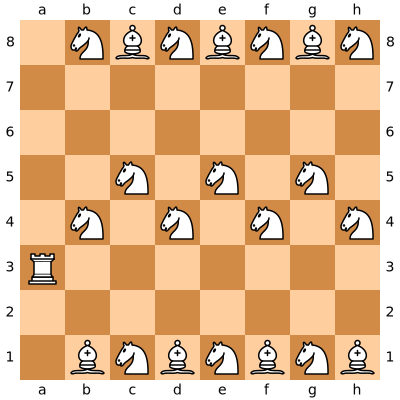

In [37]:
chess.Board("1NBNBNBN/8/8/2N1N1N1/1N1N1N1N/R7/8/1BNBNBNB")

which a score of 17/16=1.0625 and

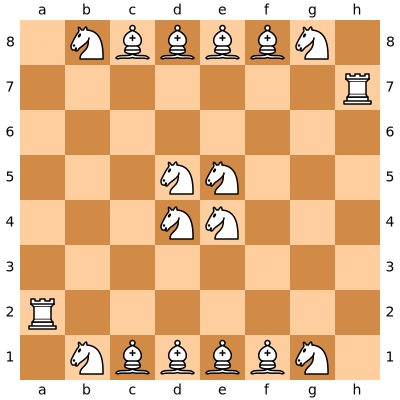

In [38]:
chess.Board("1NBBBBN1/7R/8/3NN3/3NN3/8/R7/1NBBBBN1")

with a score of 15/14 = 1.07142857142857142857.

Edward named the latter one "Four Horses on a Funeral".

It will take AI some time before it can make us laugh out loud, just by naming a chess configuration.

# References

[1] https://www.kijk.nl

[2] https://en.wikipedia.org/wiki/Eight_queens_puzzle

[3] https://lichess.org/editor/8/8/8/8/8/8/8/8_w_-_-_0_1

[4] https://pypi.org/project/python-chess/

[5] https://www.gurobi.com/

Peter Sels, March 28th 2020. Dedicated to my dad. Copyright © 2020 Logically Yours BV.